# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Problem Statement

**Utilising machine learning models as a computational technique for the diagnosis of osteoarthritis is still relatively new. The aim in this project is to develop a machine learning algorithm, and to determine if the algorithm can identify meniscus tears by differentiating/ localizing abnormalities in radiographic images of the knee.**





### Contents:
- [Background](#Background)
- [Data](#Data)



### Background
Osteoarthritis (OA) is the most prevalent medically treated arthritic condition worldwide. Diagnosis of symptomatic OA is usually made on the basis of clinical examination/ radiography and reported pain in the same joint. A meniscal tear is a frequent orthopaedic diagnosis and an early indication of OA. However, 61% of randomly selected subjects who showed meniscal tears in their knees during magnetic resonance imaging (MRI) scans, have not had any pain, aches, or stiffness during the previous months (Englund et al., 2008). So, meniscal tears are frequently encountered in both asymptomatic and symptomatic knees (Zanetti et al., 2003). Since an early detection of meniscal tear in asymptomatic knee appears to be an early indicator of OA and a risk factor for other articular structural changes, there is a need for a better and faster identification of meniscal tears (Ding et al., 2007), so that treatment options are made available early.

In [32]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# import imageio
from skimage.io import imread, imsave
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
pd.options.mode.chained_assignment = None  # default='warn'


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data 

### Training set

**read labels**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive') 

In [3]:
# /content/drive/MyDrive/Colab Notebooks/data

In [4]:
labels_train_abnormal = pd.read_csv('../data/train-abnormal.csv', names=['nr','abnormal'])
labels_train_meniscus = pd.read_csv('../data/train-meniscus.csv', names=['nr','meniscus'])
labels_train_acl = pd.read_csv('../data/train-acl.csv', names=['nr','acl'])

In [5]:
labels_valid_abnormal = pd.read_csv('../data/valid-abnormal.csv', names=['nr','abnormal'])
labels_valid_meniscus = pd.read_csv('../data/valid-meniscus.csv', names=['nr','meniscus'])
labels_valid_acl = pd.read_csv('../data/valid-acl.csv', names=['nr','acl'])

In [6]:
labels_valid_meniscus

,nr,meniscus
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0
...,...,...
115,1245,1
116,1246,1
117,1247,1
118,1248,1


**Preview of one MRI scan**

In [7]:
train_path = '../data/train/'
valid_path = '../data/valid/'

In [8]:
planes = ['axial', 'coronal', 'sagittal']
datasets = {'train': train_path, 'valid': valid_path}

In [9]:
# https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively
for dataset, path in datasets.items():
    print(f'Number of images in {dataset} set:')
    for plane in planes:
        print(plane, len(glob(f'{path}/{plane}/*.npy')))

Number of images in train set:
axial 1130
coronal 1130
sagittal 1130
Number of images in valid set:
axial 120
coronal 120
sagittal 120


In [10]:
# preview of one image
knee0000 = np.load('../data/train/coronal/0000.npy')

The data is actually made up of multiple images, and this image has 36 slides of a 256x256 pixel image. Unfortunately, not all images have the same number of slides.

In [11]:
# 36 slides of 256x256 pixal image
knee0000.shape

(36, 256, 256)

In [42]:
# image is already in array 
knee0000[14]

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

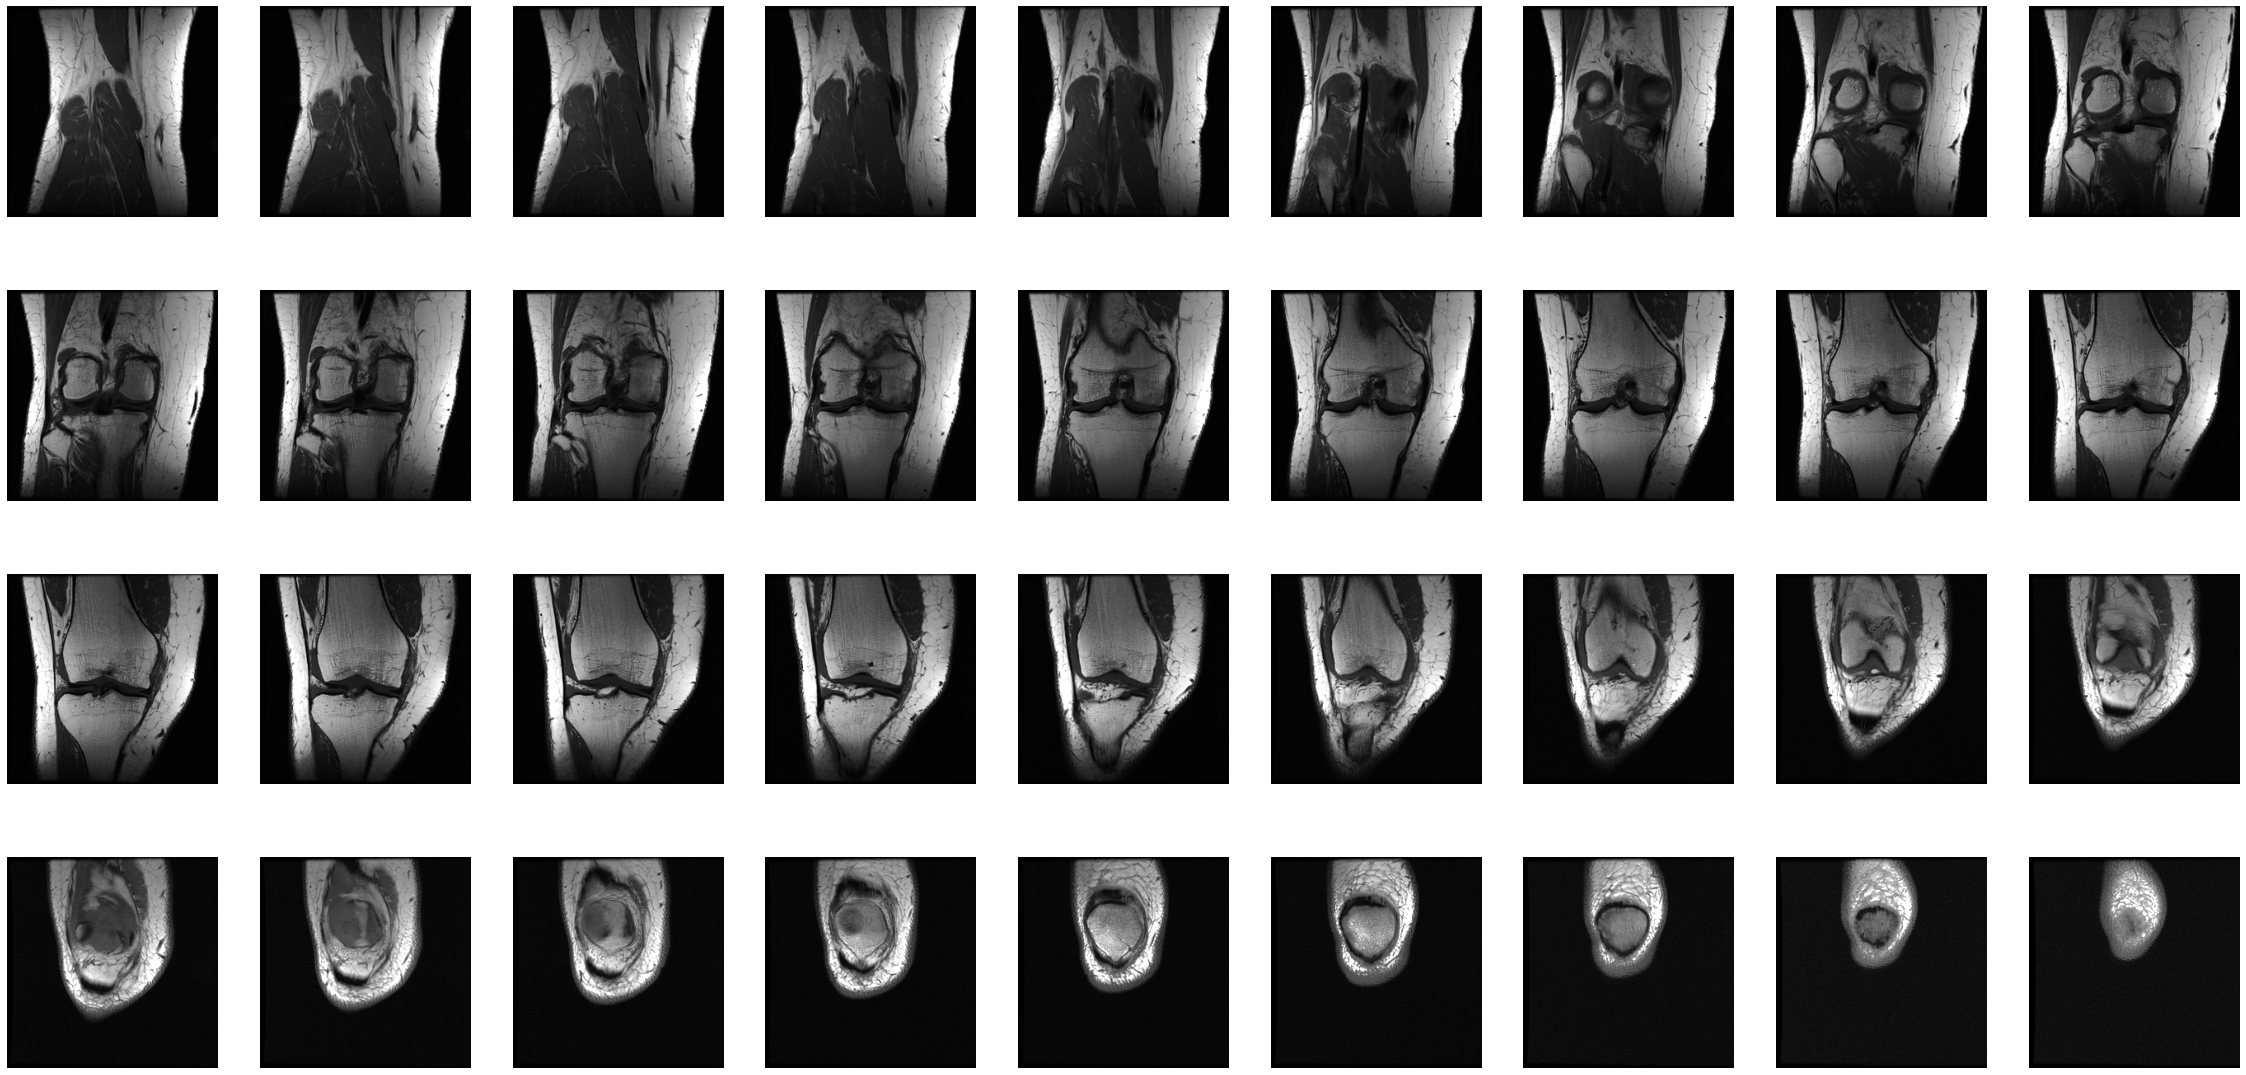

In [40]:
# preview of one mri scan
fig = plt.figure(figsize=(40, 20))

for nr, image in enumerate(knee0000):
    ax = fig.add_subplot(4, 9, nr+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off');

**Series of MRI images in the planes**

In [13]:
# #series
# coronal_path = glob(f'{train_path}/coronal/*.npy') 
# coronal_series = np.load(coronal_path[4])
# # coronal_series

In [14]:
def plot_distribution(dataset, planes):
    '''this function is to read each path, get the images, and plot the distribution'''
#     path = str(plane)+ '_path'
    if dataset == 'train':
        go = train_path
    else:
        go = valid_path 
        
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    
    for n, plane in enumerate(planes): 
        path = glob(f'{go}/' + plane + '/*.npy')

        slides = []
        for num in range(len(path)):
            image = np.load(path[num])
            slides.append(image.shape[0])
            
        print(f'{plane}: min {min(slides)}, max {max(slides)}')
            
        sns.distplot(slides, ax=axes[n])
        axes[n].set_title(f'{plane} plane')
        axes[n].set_xlabel('Nr of slides per image')

axial: min 19, max 61


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


coronal: min 17, max 58


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sagittal: min 17, max 51


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


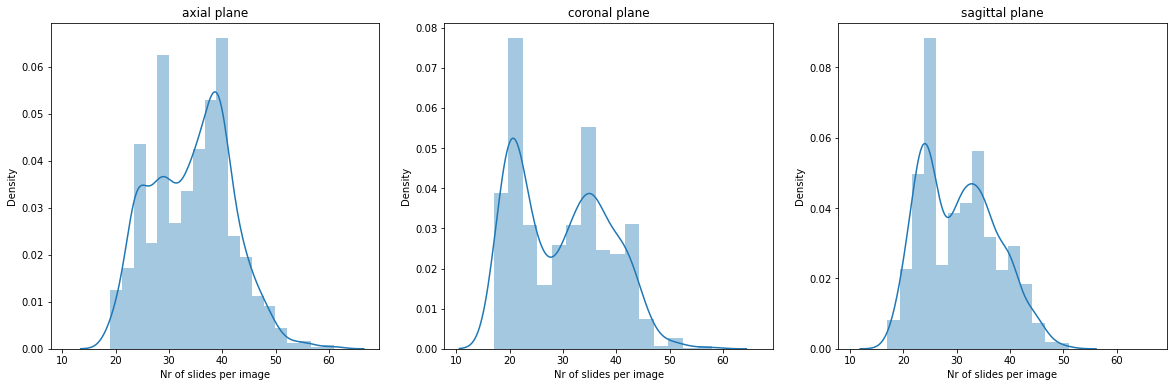

In [15]:
plot_distribution('train', planes)

The number of images in these series ranged from 17 to 61. 

**MRI sequence parameters of the images**

|             | Repetition time (ms) | Echo time (ms) | Flip angle (degrees) | Pixel bandwidth (Hz) | Echo Train Length ETL | Number of Excitations NEX | Field-of-view FOV | Sect thick (mm) | Sect gap (mm) | Number of sections | Acquisition matrix size | Reconstructed matrix size | Bit depth |
|-------------|----------------------|----------------|----------------------|----------------------|-----|-----|-----|-----------------|---------------|--------------------|-------------------------|---------------------------|-----------|
| 3T magnet   |                      |                |                      |                      |     |     |     |                 |               |                    |                         |                           |           |
| Cor T1      | 855                  | 15             | 142                  | 195.312              | 1   | 1.5 | 15  | 2.5             | 0             | 44                 | 416 x 224               | 512 x 512                 | 16        |
| Cor PD FS   | 4788                 | 36             | 142                  | 195.312              | 9   | 1   | 15  | 2.5             | 0             | 44                 | 384 x 224               | 512 x 512                 | 16        |
| Sag PD      | 3816                 | 37             | 142                  | 195.312              | 9   | 1   | 15  | 2.5             | 0             | 42                 | 384 x 224               | 512 x 512                 | 16        |
| Sag T2 FS   | 5599                 | 54             | 142                  | 195.312              | 11  | 2   | 15  | 2.5             | 0             | 42                 | 384 x 192               | 512 x 512                 | 16        |
| Ax PD FS    | 4649                 | 35             | 142                  | 195.312              | 9   | 1.5 | 15  | 3               | 0.3           | 44                 | 512 x 224               | 512 x 512                 | 16        |
| 1.5T magnet |                      |                |                      |                      |     |     |     |                 |               |                    |                         |                           |           |
| Cor T1      | 716                  | 18             | 90                   | 81.3672              | 1   | 1   | 16  | 4               | 1             | 20                 | 512 x 192               | 512 x 512                 | 16        |
| Cor T2 FS   | 4516                 | 58             | 90                   | 81.3672              | 12  | 1   | 16  | 4               | 1             | 20                 | 448 x 192               | 512 x 512                 | 16        |
| Sag PD      | 3066                 | 16             | 90                   | 81.3672              | 6   | 1   | 16  | 3               | 1             | 24                 | 512 x 192               | 512 x 512                 | 16        |
| Sag T2 FS   | 3266                 | 54             | 90                   | 81.3672              | 12  | 1   | 16  | 3.5             | 0.5           | 24                 | 448 x 192               | 512 x 512                 | 16        |
| Ax PD FS    | 4150                 | 12             | 90                   | 81.3672              | 8   | 1   | 13  | 3.5             | 0.5           | 30                 | 256 x 192               | 256 x 256                 | 16        |

The above table provides an overview of the MRI sequence parameters of the images.

**labels**

In [16]:
labels_train_abnormal['abnormal'].value_counts(normalize=True)

1    0.807965
0    0.192035
Name: abnormal, dtype: float64

In [17]:
labels_train_meniscus['meniscus'].value_counts()

0    733
1    397
Name: meniscus, dtype: int64

In [18]:
labels_train_acl['acl'].value_counts()

0    922
1    208
Name: acl, dtype: int64

**merge all labels**

In [19]:
labels_train = pd.concat([labels_train_abnormal,labels_train_meniscus,labels_train_acl], axis=1)
labels_train.drop(columns=['nr'],inplace=True)

In [20]:
# pd.set_option('display.max_row',300)
labels_train[labels_train['abnormal']==1].head(300)

,abnormal,meniscus,acl
0,1,0,0
1,1,1,1
2,1,0,0
3,1,1,0
4,1,0,0
...,...,...,...
356,1,1,0
357,1,0,0
358,1,0,0
359,1,0,0


It seems that abnormal could mean several things: -
- either acl and meniscal tears were identified
- both acl and mensical tears were identified 
- neither acl and mensical tears were identified. This would mean that the knees were diagnosed with other pathologies not mentioned.


**So comorbid conditions are present in the dataset.** How this will affect the development of the model and the results, are unknown at the moment. 
<br>
<br> The good thing is if '0' was labelled in abnormal, it's '0' in both acl and mensicus. So those labelled '0' would mean that they are relatively 'normal' knees.

**Comorbidities**

In [21]:
comorbid_train = labels_train.groupby(['abnormal','meniscus','acl']).size().reset_index().rename(columns={0:'count'})

In [22]:
comorbid_train ['percent'] = round(comorbid_train ['count']/comorbid_train ['count'].sum(),3)*100

In [23]:
comorbid_train 

,abnormal,meniscus,acl,count,percent
0,0,0,0,217,19.2
1,1,0,0,433,38.3
2,1,0,1,83,7.3
3,1,1,0,272,24.1
4,1,1,1,125,11.1


The above table shows the combinations/occurrence of abnormal, meniscus tears and acl tears. There are 433 images or 38.3% of the dataset, where meniscus and acl tears were not identified despite the images being labelled as 'abnormal'. This means that there are 433 images with other knee pathologies or injuries. 

Abnormal findings are prevalent in asymptomatic (pain-free) knees ([Horga et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32060622/)). 97% of MRI scans would show abnormalities, of which mensical tears, cartilage and bone marrow lesions are most common. So even if the dataset here reported abnomality that is NOT meniscal or ACL tears, it is highly likely that other forms of abnormalities such as bursitis, or lesions in the tendons were found.

In [24]:
labels_train[(labels_train['abnormal']==1) & (labels_train['meniscus']==0) & (labels_train['acl']==0)].head()

,abnormal,meniscus,acl
0,1,0,0
2,1,0,0
4,1,0,0
6,1,0,0
7,1,0,0


We had already had a preview of image knee0000. 

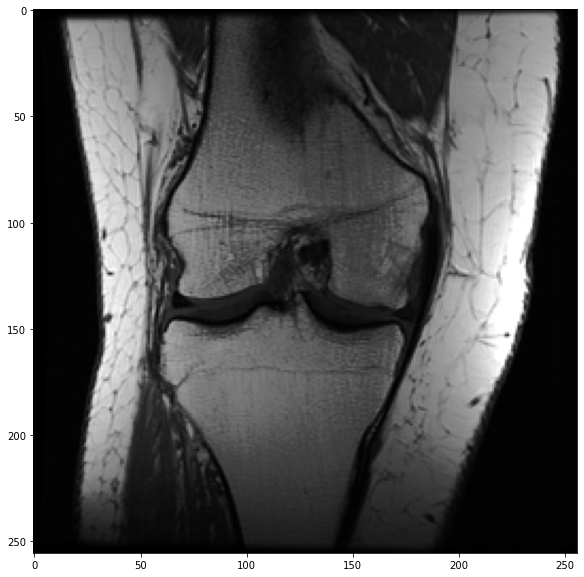

In [34]:
plt.figure(figsize=(20, 10))
plt.imshow(knee0000[14], cmap='gray'); 
imsave('knee0000.png', knee0000[14])

### Validation set

axial: min 20, max 52


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


coronal: min 17, max 48


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sagittal: min 21, max 45


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


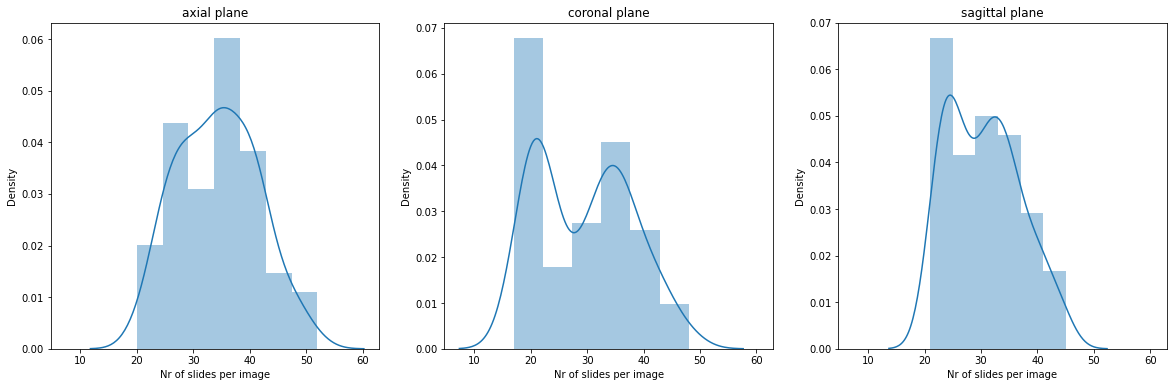

In [26]:
plot_distribution('valid', planes)

The number of images in the validation set ranged from 17 to 52. 

**merge all label**

In [27]:
labels_valid = pd.concat([labels_valid_abnormal,labels_valid_meniscus,labels_valid_acl], axis=1)
labels_valid.drop(columns=['nr'],inplace=True)

**comorbidities**

In [28]:
comorbid_valid = labels_valid.groupby(['abnormal','meniscus','acl']).size().reset_index().rename(columns={0:'count'})

In [29]:
comorbid_valid['percent'] = round(comorbid_valid['count']/comorbid_valid['count'].sum(),3)*100

In [30]:
comorbid_valid

,abnormal,meniscus,acl,count,percent
0,0,0,0,25,20.8
1,1,0,0,20,16.7
2,1,0,1,23,19.2
3,1,1,0,21,17.5
4,1,1,1,31,25.8


The above table shows the combinations/occurrence of abnormal, meniscus tears and acl tears. There are 20 images or 16.7% of the dataset, where meniscus and acl tears were not identified despite the images being labelled as 'abnormal'. This means that there are 20 images with other knee pathologies or injuries. 

**Save .npy image**

In [ ]:
# def save_imgdata(dataset_type, plane):
#     # for eg, (train, sagittal)
#     if dataset_type == 'train':
#         go = train_path
#     else:
#         go = valid_path
        
#     path = glob(f'{go}/{plane}/*.npy')
#     save_path = f'{go}/{plane}'


**export to csv**

In [ ]:
# pd.to_csv()